In [1]:
import pandas as pd

data = pd.read_csv("all_data.csv")

In [2]:
selected_features = ['ifInOctets11','ifInUcastPkts11','ifInNUcastPkts11','ifOutUcastPkts11','ifOutNUcastPkts11',
'tcpOutRsts','tcpOutSegs','tcpRetransSegs',
'udpOutDatagrams','udpNoPorts',
'ipInReceives','ipInDelivers','ipForwDatagrams',
'icmpInDestUnreachs','icmpOutDestUnreachs','class']

data_filtered = data[selected_features]

In [3]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

X = data_filtered.drop(columns=["class"])
y = data_filtered["class"]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
from xgboost import XGBClassifier

xgb = XGBClassifier(eval_metric='logloss')

In [7]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [8]:
best_xgb = grid_search.best_estimator_

In [9]:
y_pred = best_xgb.predict(X_test_scaled)

In [10]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        98
           2       1.00      1.00      1.00       130
           3       1.00      1.00      1.00       134
           4       1.00      1.00      1.00       160
           5       1.00      1.00      1.00        99
           6       1.00      1.00      1.00       190
           7       1.00      1.00      1.00       152

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [11]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(acc * 100))

Accuracy: 100.00%


In [12]:
from joblib import dump

dump(best_xgb, 'xgb-0.1.01.joblib')
dump(scaler, 'scaler-0.1.01.joblib')
dump(label_encoder, 'enc-0.1.01.joblib')

['enc-0.1.01.joblib']

In [13]:
import numpy as np

scaler_params = {'mean': scaler.mean_, 'scale': scaler.scale_}
np.save('params-0.1.01.npy', scaler_params)

Cross-validation scores: [0.99875 0.99625 0.99875 1.      1.     ]
Mean CV accuracy: 99.88%


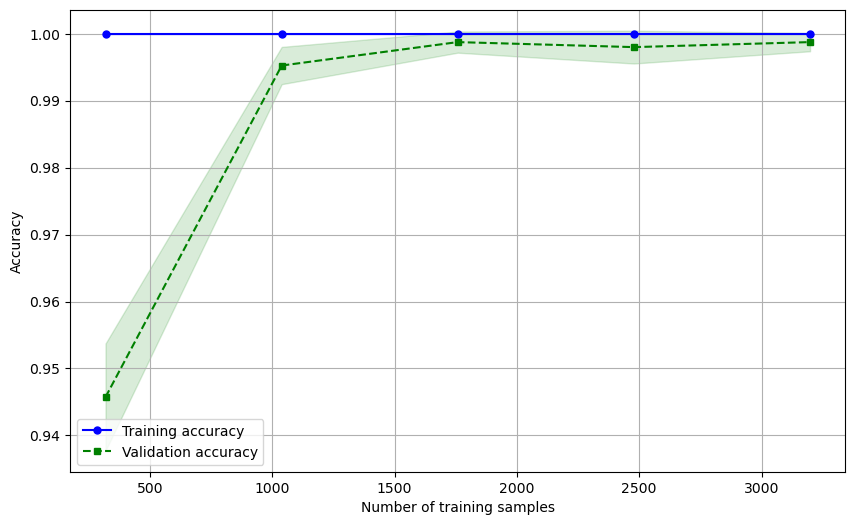

In [14]:
from sklearn.model_selection import cross_val_score, learning_curve
import matplotlib.pyplot as plt
import numpy as np

cv_scores = cross_val_score(best_xgb, X_train, y_train, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy: {:.2f}%".format(cv_scores.mean() * 100))

train_sizes, train_scores, test_scores = learning_curve(best_xgb, X_train, y_train, cv=5)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [17]:
import shap

# Define selected columns for SHAP summary plot
# selected_columns = [
#     'ifOutUcastPkts11', 'ifOutNUcastPkts11', 'tcpInSegs', 'tcpRetransSegs',
#     'tcpEstabResets', 'udpOutDatagrams', 'udpInErrors', 'udpNoPorts',
#     'ipOutDiscards', 'ipInDiscards', 'ipInAddrErrors', 'icmpInDestUnreachs',
#     'icmpOutDestUnreachs'
# ]

# Sample from reduced feature set for SHAP analysis
X_train_summary = shap.sample(X_train_scaled, 100)
# X_train_summary = X_train_summary[:, :len(selected_columns)]  # Ensure correct length
# df_X_train_summary = pd.DataFrame(X_train_summary)

# Explain with SHAP
explain = shap.Explainer(best_xgb, X_train_summary)
shap_val = explain(X_train_summary)

# Plot SHAP summary plot
shap.summary_plot(shap_val, X_train_summary)

AttributeError: `np.obj2sctype` was removed in the NumPy 2.0 release. Use `np.dtype(obj).type` instead.

In [16]:
exp = shap.Explainer(best_xgb, X_train_summary)
sv = exp.shap_values(X_train_summary)

shap.summary_plot(sv, X_train_summary)

NameError: name 'shap' is not defined